In [7]:
from qutip import *
from scipy import signal
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool

##--- Energy per spin for interaction range order---------
def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

##-- Drive-------------------------------------------------

def drive1(t, args):
    w = args['omega']
    T = 2 * np.pi/w

    sqr1 = signal.square(2 * np.pi/T * t)
    if sqr1 == -1:
        sqr1= 0
    return sqr1

def drive2(t, args):
    w = args['omega']
    T = 2 * np.pi/w

    sqr1 = -signal.square(2 * np.pi/T * t)
    if sqr1 == -1:
        sqr1= 0
    return sqr1

def drive3(t, args):    # square cos wave transverse
    w = args['omega']
    h0 = args['h0']
    h = args['h']
    T = 2 * np.pi/w

    sint = -np.sin(w*t)
    if sint<=0:
        sint = 0
    sqrsin = h0 + h * sint
    return sqrsin

def get_hamiltonian(N,N1, lambd_x, lambd_y, Jvalue, beta, g, ea, eb):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)
    H10, H11, H12, H21, H22, H23, H24 =  empt, empt, empt, empt, empt, empt, empt
    
    ##-- Hamiltonian ------------------------------------------- 
    ##-- First half

    for i in range(N1):  
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H11 = H11 + Qobj(tensor(id,tensor(sx,id1)).full()) * g * (1-ea)

    for i in range(N1,N):  
        id = qeye(2**i)    
        dim12 = N-1-i
        id1 = qeye(2**dim12)
        H12 = H12 + Qobj(tensor(id,tensor(sx,id1)).full()) * g * (1-eb)   

    ##-- Second half

    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H21 = H21 + Qobj(tensor(id, tensor(sy, tensor(id1, tensor(sy,id2)))).full()) * j_ij(Jvalue, i,j, beta)
        
    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H22 = H22 + Qobj(tensor(id,tensor(sz,id1)).full()) 

    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H23 = H23 + Qobj(tensor(id,tensor(sx,id1)).full()) * lambd_x

    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H24 = H24 + Qobj(tensor(id,tensor(sy,id1)).full()) * lambd_y
    
    return H11, H12, H21, H22, H23, H24

##-- Dynamics
def run_dynm(args):
    N,N1,lambd_x,lambd_y,Jvalue=args['N'],args['N1'],args['lambd_x'],args['lambd_y'],args['Jvalue']
    beta,g,ea,eb,w = args['beta'],args['g'],args['ea'],args['eb'],args['omega']
    h0,h,times,opts,sz_s = args['h0'],args['h'],args['times'],args['opts'], args['sz_s']
    
    H11, H12, H21, H22, H23, H24 =  get_hamiltonian(N,N1, lambd_x, lambd_y, Jvalue, beta, g, ea, eb)
    
    params = args
    
    H = [[H11,drive1], [H12,drive1],[H21,drive2], [H22,drive3], [H23,drive2], [H24,drive2]]
    grket = basis(2**N,0)        
    out = mesolve(H, grket, times, [], sz_s, args = params)
    return out.expect, beta, Jvalue

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.74s/it]


CPU times: user 2.45 s, sys: 604 ms, total: 3.06 s
Wall time: 53.8 s


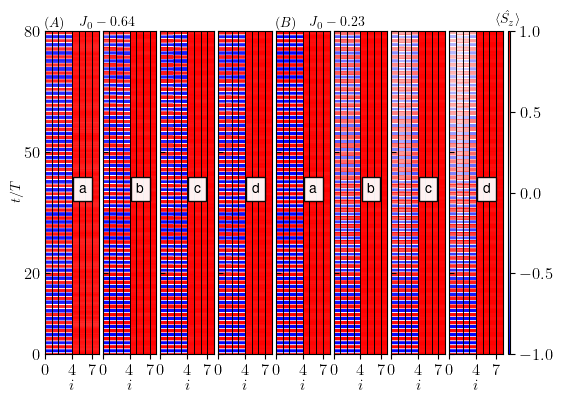

In [88]:
%%time
from qutip import *
import numpy as np
from scipy import signal
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool
from tqdm import tqdm
#from funcs import *
import h5py
from mpl_toolkits.axes_grid1 import ImageGrid

plt.rcParams.update({"figure.figsize": (6,6),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 12,"font.sans-serif": ["Helvetica"]})


fig = plt.figure()
grid = ImageGrid(fig, 111,nrows_ncols = (1,8),axes_pad = 0.04,
                 cbar_location = "right",
                 cbar_mode="single",cbar_size="4%", cbar_pad=0.05
                )

freezing_pts = jn_zeros(0, 3)

N = 8
N1= int(N/2)
N2= N-N1
omega = 20.0
w = omega
T = 2 * np.pi/w
times = np.linspace(0, 80 * T, 800, endpoint=False)

ea, eb = 0.03, 0.9
lambd_y = 0
lambd_x = 0

ft = 10   
g = np.pi/T
Jvalues = [0.072/T, 0.2/T]   
Jlbl = [r'$J_0 = 0.072/T$',r'$J_0=0.2/T$'] 
betas = [0, 1.5, 2.5, float('inf')]
labels = ['a','b', 'c', 'd', 'a','b', 'c', 'd']

nprocs = 4
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

     
spinposition_A = [0,1,2,3]
spinposition_B = [4,5,6,7]  
  
h0 = 0.0
h = freezing_pts[0] * w/4 
sx,sy,sz = sigmax(), sigmay(), sigmaz()

sz_s = []

# Region A
for m,i in enumerate(spinposition_A):
    id = qeye(2**i)    
    dim12 = N-1-i
    id1 = qeye(2**dim12)
    sz_s.append(Qobj(tensor(id,tensor(sz,id1)).full()))

# Region B
for m,i in enumerate(spinposition_B):
    id = qeye(2**i)    
    dim12 = N-1-i
    id1 = qeye(2**dim12)
    sz_s.append(Qobj(tensor(id,tensor(sz,id1)).full()))


# Weak couling parameters 
params1 = [{'h0':0, 'h':h, 'omega':omega, 'N':N,'N1':N1,\
           'opts':opts, 'sz_s':sz_s, 'lambd_y':lambd_y,\
           'lambd_x':lambd_x, 'Jvalue':Jvalues[0],'beta':beta,\
           'g':g,'ea':ea,'eb':eb, 'times':times} for beta in betas]

# Strong couling parameters 
params2 = [{'h0':0, 'h':h, 'omega':omega, 'N':N,'N1':N1,\
           'opts':opts, 'sz_s':sz_s, 'lambd_y':lambd_y,\
           'lambd_x':lambd_x, 'Jvalue':Jvalues[1],'beta':beta,\
           'g':g,'ea':ea,'eb':eb, 'times':times} for beta in betas]

params = params2 + params1   # strong + weak :coupling

data = p.map(run_dynm,tqdm(params))

datap = np.zeros((N, len(times)))
xx= 0
for i in range(N):
    datap = np.array(data[i][0])
    beta = data[i][1]
    Jvalue = data[i][2]

    xx = int(xx)
    imc = grid[xx].imshow(datap.T, aspect=0.6,interpolation="nearest",\
                    cmap='bwr', origin='lower',extent = [0 , N, times[0]/T , times[-1]/T],\
                    vmax=1, vmin=-1)
    grid[xx].text(5, 40, labels[i], fontsize=10, bbox=dict(facecolor='white', alpha=0.95))
    for i in range(N):
        grid[xx].axvline(i,color = 'black', linewidth=0.7)
    grid[xx].set_xlabel(r'$i$', fontsize=11, labelpad=0.0)
    grid[xx].set_ylabel(r'$t/T$', fontsize=10, labelpad=0.0)
    grid[xx].set_yticks([0,20,50,80])
    grid[xx].set_xticks([0,4,7])
    grid[xx].tick_params(which='both', axis="y", direction="in")
    xx=xx+1

grid[0].text(0, 81, fr"$(A)$", fontsize=10)
grid[4].text(0, 81, fr"$(B)$", fontsize=10)

grid[0].text(5, 81, fr"$  J_0 -{Jvalues[1]:2.2f}$", fontsize=10)
grid[4].text(5, 81, fr"$  J_0 -{Jvalues[0]:2.2f}$", fontsize=10)

cbticks = np.linspace(-1,1,5)
clb = plt.colorbar(imc, cax=grid.cbar_axes[0], ticks= cbticks, aspect=30) 
clb.ax.set_title(label=r"$\langle\hat{S_z}\rangle$", fontsize = 10)     
figname = "sz_t_strongJ_N_" + str(N) +'_ea_' + str(ea) + '_eb_' + str(eb) +'.svg'
plt.savefig(figname, bbox_inches='tight', pad_inches=0.0, dpi=300)

# Now change and update the codes for figures,

## 1. Strong and weak coupling at CDT/DL point and away from it

0 12.024127788478864


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:27<00:00,  3.38s/it]


1 30.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:34<00:00,  4.28s/it]


CPU times: user 3.8 s, sys: 156 ms, total: 3.96 s
Wall time: 1min 31s


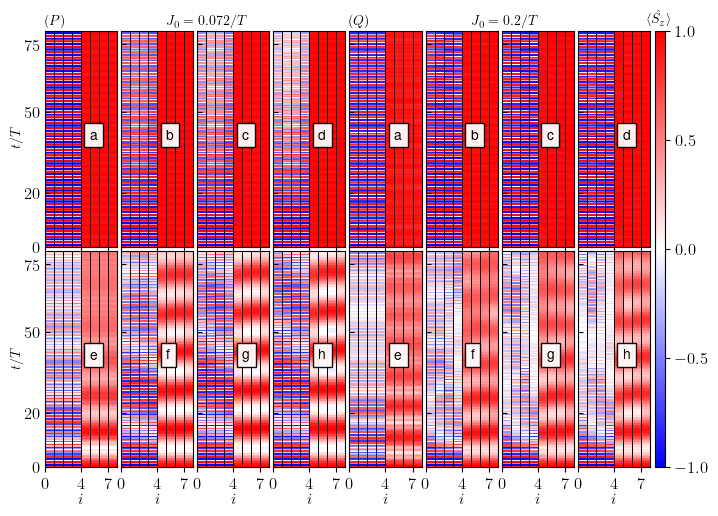

In [10]:
%%time
from qutip import *
import numpy as np
from scipy import signal
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool
from tqdm import tqdm
#from funcs import *
import h5py
from mpl_toolkits.axes_grid1 import ImageGrid

plt.rcParams.update({"figure.figsize": (8,6),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 12,"font.sans-serif": ["Helvetica"]})


fig = plt.figure()
grid = ImageGrid(fig, 111,nrows_ncols = (2,8),axes_pad = 0.04,
                 cbar_location = "right",
                 cbar_mode="single",cbar_size="7%", cbar_pad=0.05
                )
plt.subplots_adjust(hspace=0.2, wspace=0.2)

freezing_pts = jn_zeros(0, 3)

N = 8
N1= int(N/2)
N2= N-N1
omega = 20.0
w = omega
T = 2 * np.pi/w
times = np.linspace(0, 80 * T, 800, endpoint=False)

ea, eb = 0.03, 0.9
lambd_y = 0
lambd_x = 0

ft = 10   
g = np.pi/T
Jvalues = [0.072/T, 0.2/T]   
Jlbl = [r'$J_0 = 0.072/T$',r'$J_0=0.2/T$'] 
betas = [0, 1.5, 2.5, float('inf')]
labels = [['a','b', 'c', 'd', 'a','b', 'c', 'd'],['e','f','g','h','e','f','g','h']]

nprocs = 3
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

     
spinposition_A = [0,1,2,3]
spinposition_B = [4,5,6,7]  
  
h0 = 0.0
hs = [freezing_pts[0] * w/4 , 6 * w/4]
sx,sy,sz = sigmax(), sigmay(), sigmaz()

sz_s = []

# Region A
for m,i in enumerate(spinposition_A):
    id = qeye(2**i)    
    dim12 = N-1-i
    id1 = qeye(2**dim12)
    sz_s.append(Qobj(tensor(id,tensor(sz,id1)).full()))

# Region B
for m,i in enumerate(spinposition_B):
    id = qeye(2**i)    
    dim12 = N-1-i
    id1 = qeye(2**dim12)
    sz_s.append(Qobj(tensor(id,tensor(sz,id1)).full()))

xx = 0

for hh, h in enumerate(hs):
    print(hh,h)
    
    # Weak couling parameters 
    params1 = [{'h0':0, 'h':h, 'omega':omega, 'N':N,'N1':N1,\
               'opts':opts, 'sz_s':sz_s, 'lambd_y':lambd_y,\
               'lambd_x':lambd_x, 'Jvalue':Jvalues[0],'beta':beta,\
               'g':g,'ea':ea,'eb':eb, 'times':times} for beta in betas]
    
    # Strong couling parameters 
    params2 = [{'h0':0, 'h':h, 'omega':omega, 'N':N,'N1':N1,\
               'opts':opts, 'sz_s':sz_s, 'lambd_y':lambd_y,\
               'lambd_x':lambd_x, 'Jvalue':Jvalues[1],'beta':beta,\
               'g':g,'ea':ea,'eb':eb, 'times':times} for beta in betas]
    
    params = params1 + params2   # strong + weak :coupling
    
    data = p.map(run_dynm,tqdm(params))
    
    datap = np.zeros((N, len(times)))
    
    for i in range(N):
        datap = np.array(data[i][0])
        beta = data[i][1]
        Jvalue = data[i][2]
    
        xx = int(xx)
        imc = grid[xx].imshow(datap.T, aspect=0.3,interpolation="nearest",\
                        cmap='bwr', origin='lower',extent = [0 , N, times[0]/T , times[-1]/T],\
                        vmax=1, vmin=-1)
        grid[xx].text(5, 40, labels[hh][i], fontsize=10, bbox=dict(facecolor='white', alpha=0.95))
        for i in range(N):
            grid[xx].axvline(i,color = 'black', linewidth=0.7)
        grid[xx].set_xlabel(r'$i$', fontsize=11, labelpad=0.0)
        grid[xx].set_ylabel(r'$t/T$', fontsize=10, labelpad=0.0)
        grid[xx].set_yticks([0,20,50,75])
        grid[xx].set_xticks([0,4,7])
        grid[xx].tick_params(which='both', axis="y", direction="in")

        xx=xx+1
        
grid[0].text(0, 82, fr"$(P)$", fontsize=10)
grid[4].text(0, 82, fr"$(Q)$", fontsize=10)
grid[1].text(5, 82, Jlbl[0], fontsize=10)
grid[5].text(5, 82, Jlbl[1], fontsize=10)

cbticks = np.linspace(-1,1,5)
clb = plt.colorbar(imc, cax=grid.cbar_axes[0], ticks= cbticks, aspect=30) 
clb.ax.set_title(label=r"$\langle\hat{S_z}\rangle$", fontsize = 10)     
figname = "sz_t_strongJ_N_" + str(N) +'_ea_' + str(ea) + '_eb_' + str(eb) +'.svg'
figname1 = "sz_t_strongJ_N_" + str(N) +'_ea_' + str(ea) + '_eb_' + str(eb) +'.pdf'
plt.savefig(figname, bbox_inches='tight', pad_inches=0.0, dpi=300)
#plt.savefig(figname1, bbox_inches='tight', pad_inches=0.0)

## FFT local

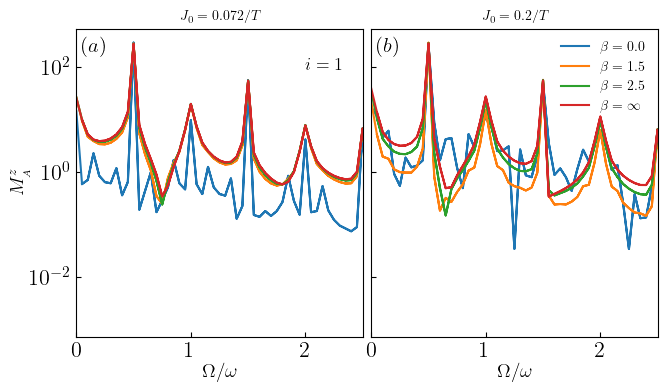

CPU times: user 37.9 s, sys: 649 ms, total: 38.5 s
Wall time: 40 s


In [21]:
%%time
from qutip import *
import numpy as np
from scipy import signal
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool
from tqdm import tqdm
from funcs import *


freezing_pts = jn_zeros(0, 3)
plt.rcParams.update({"figure.figsize": (7.5, 4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 16,"font.sans-serif": ["Helvetica"]})


def fourier_transform(data, d):
    n = len(data)
    frequencies = np.fft.fftfreq(n, d)
    fft_values = np.fft.fft(data)    
    return frequencies, fft_values

N = 8
N1= int(N/2)
N2= N-N1
omega = 20.0
w = omega
T = 2 * np.pi/w
steps = 500
times = np.linspace(0, 20 * T, steps, endpoint=False)
d = 1/steps

ea, eb = 0.03, 0.9
lambd_y = 0
lambd_x = 0

ft = 10   
g = np.pi/T
Jvalues = [0.072/T, 0.2/T]   
Jlbl = [r'$J_0 = 0.072/T$',r'$J_0=0.2/T$'] 
betas = [0, 1.5, 2.5, float('inf')]
fig, axs = plt.subplots(1,2, sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.03, hspace=0.0)

for bt, beta in enumerate(betas):    
    for jh,Jvalue in enumerate(Jvalues):
        nprocs = N1
        p = Pool(processes = nprocs) 
        opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

        spinposition_A = [1]
        ia = spinposition_A[0]
        spinposition_B = [4] 

        h0 = 0.0
        h = freezing_pts[0] * w/4 
        sx,sy,sz = sigmax(), sigmay(), sigmaz()

        i = ia
        id = qeye(2**i)    
        dim12 = N-1-i
        id1 = qeye(2**dim12)
        sz_o = Qobj(tensor(id,tensor(sz,id1)).full())

        params = {'h0':0, 'h':h, 'omega':omega, 'N':N,'N1':N1,\
                   'opts':opts, 'sz_o':sz_o, 'lambd_y':lambd_y,\
                   'lambd_x':lambd_x, 'Jvalue':Jvalue,'beta':beta,\
                   'g':g,'ea':ea,'eb':eb, 'times':times}

        data2 = run_dynm(params)
        mz_dt = data2[0] 
        mz_data = mz_dt
        frequencies, fft_values = fourier_transform(mz_data, d)
        
        if bt == 3:
            axs[jh].plot(np.abs(frequencies)/w, np.abs(fft_values), label = fr"$\beta=\infty$")
        else:
            axs[jh].plot(np.abs(frequencies)/w, np.abs(fft_values), label = fr"$\beta={beta:1.1f}$")
        axs[-1].legend(frameon=False, fontsize =10, loc =1)
        
        
        axs[jh].tick_params(which='both', axis="both", direction="in")
        axs[jh].set_title(Jlbl[jh], fontsize= 10)
        axs[jh].set_yscale('log')
        axs[jh].set_xlabel(r"$\Omega/\omega$", fontsize = 14, labelpad= 0.5)
        
axs[0].set_ylabel(r"$M^z_{_{A}}$",fontsize = 14, labelpad= 0.0) 
axs[0].text(0.05, 2e2, r'$(a)$', fontsize=15)
axs[1].text(0.05, 2e2, r'$(b)$', fontsize=15)

plt.savefig('clean_J_strong_MzAB_betas.pdf', bbox_inches='tight', pad_inches=0.0, dpi = 600)
plt.savefig('clean_J_strong_MzAB_betas.svg', bbox_inches='tight', pad_inches=0.0, dpi = 600)
axs[0].text(2, 90.0, fr"$i={ia:1d}$", fontsize=13,\
            bbox=dict(facecolor='white', alpha=1.0, edgecolor='white'))


plt.xlim(0,2.5)
plt.savefig('single_sz_fft.pdf', bbox_inches='tight', pad_inches=0.0, dpi = 300)
plt.show()

### FFT regional

0it [00:00, ?it/s]WARNING:matplotlib.legend:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
4it [00:45, 11.25s/it]


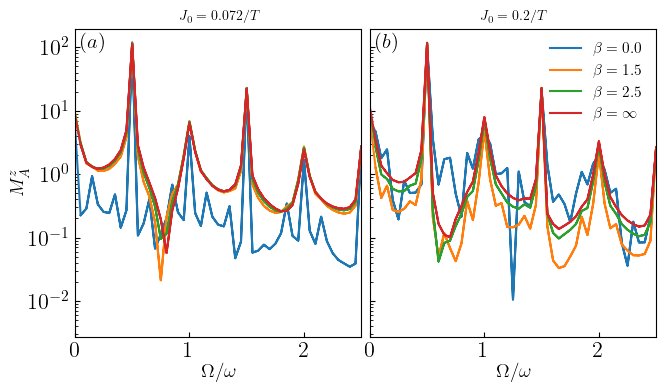

CPU times: user 3.67 s, sys: 581 ms, total: 4.26 s
Wall time: 48.5 s


In [24]:
%%time
from qutip import *
import numpy as np
from scipy import signal
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool
from tqdm import tqdm
from funcs import *


freezing_pts = jn_zeros(0, 3)
plt.rcParams.update({"figure.figsize": (7.5, 4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 16,"font.sans-serif": ["Helvetica"]})


def fourier_transform(data, d):
    n = len(data)
    frequencies = np.fft.fftfreq(n, d)
    fft_values = np.fft.fft(data)    
    return frequencies, fft_values

N = 8
N1= int(N/2)
N2= N-N1
omega = 20.0
w = omega
T = 2 * np.pi/w
steps = 201
times = np.linspace(0, 20 * T, steps, endpoint=False)
d = 1/steps

ea, eb = 0.03, 0.9
lambd_y = 0
lambd_x = 0

ft = 10   
g = np.pi/T
Jvalues = [0.072/T, 0.2/T]   
Jlbl = [r'$J_0 = 0.072/T$',r'$J_0=0.2/T$'] 
betas = [0, 1.5, 2.5, float('inf')]
fig, axs = plt.subplots(1,2, sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.03, hspace=0.0)

for bt, beta in tqdm(enumerate(betas)):    
    for jh,Jvalue in enumerate(Jvalues):
        nprocs = N1
        p = Pool(processes = nprocs) 
        opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

        spinposition_A = [0,1,2,3]
        spinposition_B = [4,5,6,7] 

        h0 = 0.0
        h = freezing_pts[0] * w/4 
        sx,sy,sz = sigmax(), sigmay(), sigmaz()
        sz_os = [] 
        for m,i in enumerate(spinposition_A):
            id = qeye(2**i)    
            dim12 = N-1-i
            id1 = qeye(2**dim12)
            sz_os.append(Qobj(tensor(id,tensor(sz,id1)).full()))

        params = [{'h0':0, 'h':h, 'omega':omega, 'N':N,'N1':N1,\
                   'opts':opts, 'sz_o':sz_o, 'lambd_y':lambd_y,\
                   'lambd_x':lambd_x, 'Jvalue':Jvalue,'beta':beta,\
                   'g':g,'ea':ea,'eb':eb, 'times':times} for sz_o in sz_os]

        data2 = p.map(run_dynm,params)
        mz_dt = [data2[m][0] for m in range(N1)]
        mz_data = np.sum(mz_dt, axis=0) * 2/N
        frq, fftq = [], []
        frequencies, fft_values = fourier_transform(mz_data, d)
        
        if bt == 3:
            axs[jh].plot(np.abs(frequencies)/w, np.abs(fft_values), label = fr"$\beta=\infty$")
        else:
            axs[jh].plot(np.abs(frequencies)/w, np.abs(fft_values), label = fr"$\beta={beta:1.1f}$")
        axs[-1].legend(frameon=False, fontsize=11)
        
        
        axs[jh].tick_params(which='both', axis="x", direction="in")
        axs[jh].tick_params(which='both', axis="y", direction="in")
        axs[jh].set_title(Jlbl[jh], fontsize= 10)
        axs[jh].set_yscale('log')
        axs[jh].set_xlabel(r"$\Omega/\omega$", fontsize = 14, labelpad= 0.5)
        
axs[0].text(0.05, 1e2, r'$(a)$', fontsize=15)
axs[1].text(0.05, 1e2, r'$(b)$', fontsize=15)
axs[0].set_ylabel(r"$M^z_{A}$",fontsize = 14, labelpad= 0.0)  

plt.xlim(0,2.5)
plt.savefig('sz_regional_fft.pdf', bbox_inches='tight', pad_inches=0.0)
plt.savefig('sz_regional_fft.svg', bbox_inches='tight', pad_inches=0.0, dpi = 300)
plt.show()

## rotational error eas = 0.05, 0.1

In [34]:
from qutip import *
from scipy import signal
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool

##--- Energy per spin for interaction range order---------
def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

##-- Drive-------------------------------------------------

def drive1(t, args):
    w = args['omega']
    T = 2 * np.pi/w

    sqr1 = signal.square(2 * np.pi/T * t)
    if sqr1 == -1:
        sqr1= 0
    return sqr1

def drive2(t, args):
    w = args['omega']
    T = 2 * np.pi/w

    sqr1 = -signal.square(2 * np.pi/T * t)
    if sqr1 == -1:
        sqr1= 0
    return sqr1

def drive3(t, args):    # square cos wave transverse
    w = args['omega']
    h0 = args['h0']
    h = args['h']
    T = 2 * np.pi/w

    sint = -np.sin(w*t)
    if sint<=0:
        sint = 0
    sqrsin = h0 + h * sint
    return sqrsin

def get_hamiltonian(N,N1, lambd_x, lambd_y, Jvalue, beta, g, ea, eb):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)
    H10, H11, H12, H21, H22, H23, H24 =  empt, empt, empt, empt, empt, empt, empt
    
    ##-- Hamiltonian ------------------------------------------- 
    ##-- First half

    for i in range(N1):  
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H11 = H11 + Qobj(tensor(id,tensor(sx,id1)).full()) * g * (1-ea)

    for i in range(N1,N):  
        id = qeye(2**i)    
        dim12 = N-1-i
        id1 = qeye(2**dim12)
        H12 = H12 + Qobj(tensor(id,tensor(sx,id1)).full()) * g * (1-eb)   

    ##-- Second half

    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H21 = H21 + Qobj(tensor(id, tensor(sy, tensor(id1, tensor(sy,id2)))).full()) * j_ij(Jvalue, i,j, beta)
        
    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H22 = H22 + Qobj(tensor(id,tensor(sz,id1)).full()) 

    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H23 = H23 + Qobj(tensor(id,tensor(sx,id1)).full()) * lambd_x

    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H24 = H24 + Qobj(tensor(id,tensor(sy,id1)).full()) * lambd_y
    
    return H11, H12, H21, H22, H23, H24

##-- Dynamics
def run_dynm(args):
    N,N1,lambd_x,lambd_y,Jvalue=args['N'],args['N1'],args['lambd_x'],args['lambd_y'],args['Jvalue']
    beta,g,ea,eb,w = args['beta'],args['g'],args['ea'],args['eb'],args['omega']
    h0,h,times,opts,sz_s = args['h0'],args['h'],args['times'],args['opts'], args['sz_s']
    
    H11, H12, H21, H22, H23, H24 =  get_hamiltonian(N,N1, lambd_x, lambd_y, Jvalue, beta, g, ea, eb)
    
    params = args
    
    H = [[H11,drive1], [H12,drive1],[H21,drive2], [H22,drive3], [H23,drive2], [H24,drive2]]
    grket = basis(2**N,0)        
    out = mesolve(H, grket, times, [], sz_s, args = params)
    return out.expect, beta, Jvalue, ea

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:35<00:00,  4.49s/it]


CPU times: user 1.9 s, sys: 108 ms, total: 2.01 s
Wall time: 1min 10s


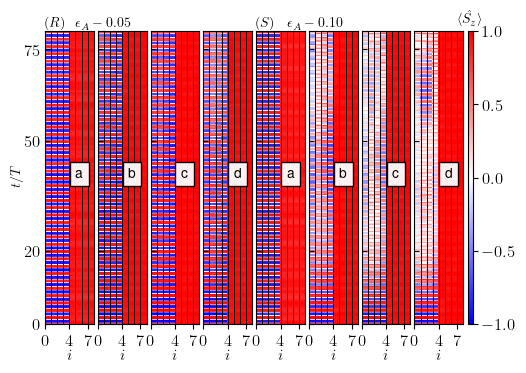

In [46]:
%%time
from qutip import *
import numpy as np
from scipy import signal
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool
from tqdm import tqdm
#from funcs import *
import h5py
from mpl_toolkits.axes_grid1 import ImageGrid

plt.rcParams.update({"figure.figsize": (6,3.8),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 12,"font.sans-serif": ["Helvetica"]})


fig = plt.figure()
grid = ImageGrid(fig, 111,nrows_ncols = (1,8),axes_pad = 0.04,
                 cbar_location = "right",
                 cbar_mode="single",cbar_size="9%", cbar_pad=0.05
                )

freezing_pts = jn_zeros(0, 3)

N = 8
N1= int(N/2)
N2= N-N1
omega = 20.0
w = omega
T = 2 * np.pi/w
times = np.linspace(0, 80 * T, 2000, endpoint=False)

eb = 0.9
eas = [0.05, 0.1]
lambd_y = 0
lambd_x = 0

ft = 10   
g = np.pi/T
Jvalues = 0.2/T
Jlbl = [r'$J_0 = 0.072/T$',r'$J_0=0.2/T$'] 
betas = [0, 1.5, 2.5, float('inf')]
labels = ['a','b', 'c', 'd', 'a','b', 'c', 'd']

nprocs = 4
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

spinposition_A = [0,1,2,3]
spinposition_B = [4,5,6,7]  
  
h0 = 0.0
h = freezing_pts[0] * w/4 
sx,sy,sz = sigmax(), sigmay(), sigmaz()

sz_s = []

# Region A
for m,i in enumerate(spinposition_A):
    id = qeye(2**i)    
    dim12 = N-1-i
    id1 = qeye(2**dim12)
    sz_s.append(Qobj(tensor(id,tensor(sz,id1)).full()))

# Region B
for m,i in enumerate(spinposition_B):
    id = qeye(2**i)    
    dim12 = N-1-i
    id1 = qeye(2**dim12)
    sz_s.append(Qobj(tensor(id,tensor(sz,id1)).full()))


# Weak couling parameters 
params1 = [{'h0':0, 'h':h, 'omega':omega, 'N':N,'N1':N1,\
           'opts':opts, 'sz_s':sz_s, 'lambd_y':lambd_y,\
           'lambd_x':lambd_x, 'Jvalue':Jvalue,'beta':beta,\
           'g':g,'ea':eas[0],'eb':eb, 'times':times} for beta in betas]

# Strong couling parameters 
params2 = [{'h0':0, 'h':h, 'omega':omega, 'N':N,'N1':N1,\
           'opts':opts, 'sz_s':sz_s, 'lambd_y':lambd_y,\
           'lambd_x':lambd_x, 'Jvalue':Jvalue,'beta':beta,\
           'g':g,'ea':eas[1],'eb':eb, 'times':times} for beta in betas]

params = params1 + params2   

data = p.map(run_dynm,tqdm(params))

datap = np.zeros((N, len(times)))

xx= 0
for i in range(N):
    datap = np.array(data[i][0])
    beta = data[i][1]
    Jvalue = data[i][2]
    ea = data[i][3]

    xx = int(xx)
    imc = grid[xx].imshow(datap.T, aspect=0.6,interpolation="nearest",\
                    cmap='bwr', origin='lower',extent = [0 , N, times[0]/T , times[-1]/T],\
                    vmax=1, vmin=-1)
    grid[xx].text(5, 40, labels[i], fontsize=10, bbox=dict(facecolor='white', alpha=0.95))
    for i in range(N):
        grid[xx].axvline(i,color = 'black', linewidth=0.7)
    grid[xx].set_xlabel(r'$i$', fontsize=11, labelpad=0.0)
    grid[xx].set_ylabel(r'$t/T$', fontsize=10, labelpad=0.0)
    grid[xx].set_yticks([0,20,50,75])
    grid[xx].set_xticks([0,4,7])
    grid[xx].tick_params(which='both', axis="y", direction="in")
    xx=xx+1

grid[0].text(0, 81, fr"$(R)$", fontsize=10)
grid[4].text(0, 81, fr"$(S)$", fontsize=10)

grid[0].text(5, 81, fr"$\epsilon_A -{eas[0]:1.2f}$", fontsize=10)
grid[4].text(5, 81, fr"$\epsilon_A -{eas[1]:1.2f}$", fontsize=10)

cbticks = np.linspace(-1,1,5)
clb = plt.colorbar(imc, cax=grid.cbar_axes[0], ticks= cbticks, aspect=30) 
clb.ax.set_title(label=r"$\langle\hat{S_z}\rangle$", fontsize = 10)     
figname = 'sz_t_strongJ_N_' + str(N) +'_eas_' + str(eas[0]) +'_'+ str(eas[1])+'_.svg'
plt.savefig(figname, bbox_inches='tight', pad_inches=0.0, dpi=300)

### Regional magnetization and FFT for extended time period

In [1]:
!ls RegMz_8*>mz8files.txt

In [2]:
cat mz8files.txt

RegMz_8_j_0.22918311805232927_beta_0.hdf5
RegMz_8_j_0.22918311805232927_beta_1.5.hdf5
RegMz_8_j_0.22918311805232927_beta_2.5.hdf5
RegMz_8_j_0.22918311805232927_beta_inf.hdf5
RegMz_8_j_0.6366197723675814_beta_0.hdf5
RegMz_8_j_0.6366197723675814_beta_1.5.hdf5
RegMz_8_j_0.6366197723675814_beta_2.5.hdf5
RegMz_8_j_0.6366197723675814_beta_inf.hdf5


RegMz_8_j_0.22918311805232927_beta_0.hdf5
beta 0
RegMz_8_j_0.22918311805232927_beta_1.5.hdf5
beta 1.5
RegMz_8_j_0.22918311805232927_beta_2.5.hdf5
beta 2.5
RegMz_8_j_0.22918311805232927_beta_inf.hdf5
beta inf
RegMz_8_j_0.6366197723675814_beta_0.hdf5
beta 0
RegMz_8_j_0.6366197723675814_beta_1.5.hdf5
beta 1.5
RegMz_8_j_0.6366197723675814_beta_2.5.hdf5
beta 2.5
RegMz_8_j_0.6366197723675814_beta_inf.hdf5
beta inf


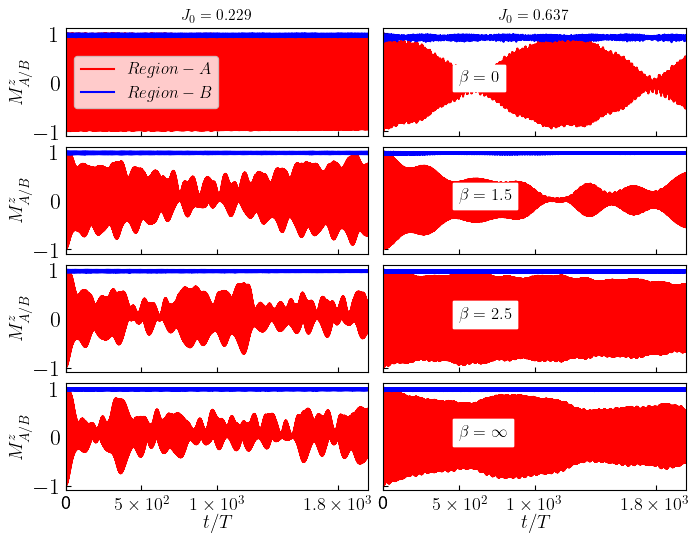

In [3]:
import matplotlib.pyplot as plt
import h5py
import numpy as np

plt.rcParams.update({"figure.figsize": (8., 6),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 16,"font.sans-serif": ["Helvetica"]})
w = 20
T = 2 * np.pi/w
jvalues = [0.072/T,0.2/T]

fig, axs = plt.subplots(4, 2, sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.05, hspace=0.1)

with open("mz8files.txt", 'r') as fp:
    lines = fp.readlines()
    x = len(lines)
    for i in range(0,x):
        filename = lines[i][:-1]
        print(filename)
        with h5py.File(filename, "r") as f:
            data_a = f['mza'][()]
            data_b = f['mzb'][()]
            times = f['times'][()]
            N = f.attrs['N']
            Jvalue = f.attrs['Jvalue']
            beta = f.attrs['beta']
            w = f.attrs['w']

            print('beta',beta)
            
            if Jvalue == jvalues[0]:
                jh = 0
            else:
                jh = 1
                
            if beta == 0:
                ii = 0
                lbl = fr"$\beta={beta}$"
            if beta == 1.5:
                ii = 1
                lbl = fr"$\beta={beta}$"
            if beta == 2.5:
                ii = 2
                lbl = fr"$\beta={beta}$"
            if beta == float('inf'):
                ii = 3
                lbl = r"$\beta={\infty}$"
                
            
            axs[ii][jh].plot(times/T, data_a, color='red', label= r"$Region-A$")            
            axs[ii][jh].plot(times/T, data_b, color='blue', label= r"$Region-B$")
                
            axs[0][0].legend(frameon = True, loc = 6, fontsize = 12)

            axs[ii][jh].set_xlim(0, 2000)
            #axs[ii][jh].set_xscale('log')
            axs[ii][jh].tick_params(which='both', axis="x", direction="in")
            axs[ii][jh].tick_params(which='both', axis="y", direction="in")
            axs[0][jh].set_title(fr"$J_0 = {Jvalue:1.3f}$", fontsize= 11)
            
            

            axs[ii][0].set_ylabel(r"$M^z_{A/B}$",fontsize = 14, labelpad= 0.0)  
            
            if ii ==3:
                axs[ii][1].text(500, 0.0, lbl, fontsize=12, bbox=dict(facecolor='white', alpha=1.0, edgecolor='white'))
            else:
                axs[ii][1].text(500, 0.0, lbl, fontsize=12, bbox=dict(facecolor='white', alpha=1.0, edgecolor='white'))
            
            
axs[3][0].set_xlabel(r"$t/T$", fontsize = 14, labelpad= 0.5)
axs[3][0].set_xticks([0, 5e2, 1e3, 1.8e3])
axs[3][0].set_xticklabels(['0', r"$5 \times 10^2$",\
                           r"$1 \times 10^3$",r"$1.8 \times 10^3$"], fontsize = 13)

axs[3][1].set_xlabel(r"$t/T$", fontsize = 14, labelpad= 0.5)
axs[3][1].set_xticks([0, 5e2, 1e3, 1.8e3])
axs[3][1].set_xticklabels([0, r"$5 \times 10^2$",\
                           r"$1 \times 10^3$",r"$1.8 \times 10^3$"], fontsize = 13)


#plt.savefig('mz_betas.pdf', bbox_inches='tight', pad_inches=0.0, dpi = 600)
plt.savefig('regional_mz_betas.svg', bbox_inches='tight', pad_inches=0.0, dpi = 600)
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 30.13it/s]


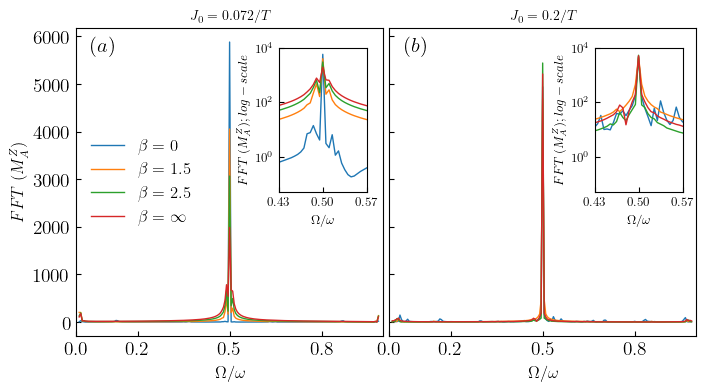

In [110]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import h5py
import numpy as np
from tqdm import tqdm

plt.rcParams.update({"figure.figsize": (8, 4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 14,"font.sans-serif": ["Helvetica"]})

w = 20
T = 2 * np.pi/w
jvalues = [0.072/T,0.2/T]
Jlbl = [r'$J_0 = 0.072/T$',r'$J_0=0.2/T$'] 

freq_threshold_left = 0.01
freq_threshold_right = 0.99

fig, axs = plt.subplots(1, 2, sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.02, hspace=0.0)

#left, bottom, width, height = [0.45, 0.33, 0.4, 0.32]
ax2 = fig.add_axes([0.3783, 0.47, 0.11, 0.36])
ax3 = fig.add_axes([0.773, 0.47, 0.11, 0.36])

with open("mz8files.txt", 'r') as fp:
    lines = fp.readlines()
    x = len(lines)
    for i in tqdm(range(0,x)):
        filename = lines[i][:-1]
        with h5py.File(filename, "r") as f:
            data_a = f['mza'][()]
            data_b = f['mzb'][()]
            times = f['times'][()]
            N = f.attrs['N']
            Jvalue = f.attrs['Jvalue']
            beta = f.attrs['beta']
            w = f.attrs['w']
            
            if Jvalue == jvalues[0]:
                jh = 0
            else:
                jh = 1
                
            if beta == 0:
                ii = 0
                lbl = fr"$\beta={beta}$"
            if beta == 1.5:
                ii = 1
                lbl = fr"$\beta={beta}$"
            if beta == 2.5:
                ii = 2
                lbl = fr"$\beta={beta}$"
            if beta == float('inf'):
                ii = 3
                lbl = r"$\beta={\infty}$"

            data = data_a[0:10000]
            frequencies = T * np.fft.fftfreq(len(data), times[-1]/len(times))
            fft_values = np.fft.fft(data)

            mask = (frequencies > freq_threshold_left) & (frequencies < freq_threshold_right)
            y = np.abs(fft_values[mask])
            x = frequencies[mask]
    
            axs[jh].set_title(Jlbl[jh], fontsize= 10)
            axs[jh].plot(np.abs(x), np.abs(y),  label= lbl,linewidth  = 1)  
            axs[jh].set_xticks([0,.2,.5,.8])
            axs[jh].set_xlim(0, 1)            
            axs[jh].tick_params(which='both', axis="both", direction="in")
            
            if jh ==0:
                ax2.plot(np.abs(x), np.abs(y), linewidth=1)
                ax2.set_xlim(0.43,0.57)
                ax2.set_ylim(0.05,1e4)
                ax2.set_xticks([.43, 0.5, .57])
                ax2.set_yscale('log')
                ax2.set_ylabel(r'$FFT\;(M^Z_A);log-scale$', fontsize=9)
                ax2.tick_params(which='both', axis="both", direction="in", labelsize = 9)
                ax2.set_xlabel(r'$\Omega/\omega$', fontsize = 9)   
            
            if jh ==1:
                ax3.plot(np.abs(x), np.abs(y), linewidth=1)
                ax3.set_xlim(0.43,0.57)
                ax3.set_ylim(0.05,1e4)
                ax3.set_xticks([.43, 0.5, .57])
                ax3.set_yscale('log')
                ax3.set_ylabel(r'$FFT\;(M^Z_A);log-scale$', fontsize=9)
                ax3.tick_params(which='both', axis="both", direction="in", labelsize = 9)
                ax3.set_xlabel(r'$\Omega/\omega$', fontsize = 9)   
            
            axs[jh].set_xlabel(r'$\Omega/\omega$', fontsize = 12)                
axs[0].legend(frameon = False, loc = 6, fontsize = 12)
axs[0].set_ylabel(r'$FFT\;(M^Z_A)$', fontsize = 12)

axs[0].text(0.05, 5.7e3, r'$(a)$', fontsize=15)
axs[1].text(0.05, 5.7e3, r'$(b)$', fontsize=15)

#plt.savefig('fft_mz_betas.pdf', bbox_inches='tight', pad_inches=0.0, dpi = 600)
plt.savefig('fft_regional_mz_betas.svg', bbox_inches='tight', pad_inches=0.0, dpi = 300)

plt.show()